# Metric Analysis

The tabular results of evaluating the metrics for all survey designs and all science cases can be found in the metric_results/ directory.  The goal of this notebook is to explore those results in graphical form. 

In [1]:
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
from astropy.table import Table, Column, vstack
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import config_utils
import regions
import visualization_utils
import numpy as np
from astropy import units as u 
from mw_plot import MWSkyMap

First we need to load some of the configuration information for the metric simulation for future reference.

In [3]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

In [4]:
# Load the survey regions
all_survey_regions = regions.load_regions_from_file(sim_config, path.join(sim_config['root_dir'], 'config', 'rgps_survey_regions.json'))

# Load survey designs 
#all_survey_designs = config_utils.read_config(path.join(sim_config['root_dir'], 'config', 'rgps_survey_definitions.json'))

## M1 Survey Footprint metric results 

The M1 metric evaluates the overlap between the survey regions requested by the different science cases and those actually included in each survey design.  Note that if a science case or strategy includes multiple regions per filter, the metric the sums the overlapping HEALpixel area for all regions.  

In [6]:
# Load the M1 metric results
m1_results_file = path.join(getcwd(), '..', 'metric_results', 'M1_survey_footprint_results.txt')

m1_results = Table.read(m1_results_file, format='ascii')
m1_results

Survey_strategy,Optic,Science_case,M1_%pix,M1_%priority
str9,str4,str11,float64,float64
wide_area,F213,Paladini,61.1671469740634,63.383020090732344
wide_area,F087,Kruszynska,0.0,0.0
wide_area,F213,Kruszynska,43.77828054298642,43.77828054298642
wide_area,F106,Hunt,0.0,0.0
wide_area,F129,Hunt,78.97196261682244,78.97196261682244
wide_area,F158,Hunt,78.97196261682244,78.97196261682244
wide_area,F213,Hunt,78.97196261682244,78.97196261682244
wide_area,F158,Freeman,25.0,25.0
wide_area,F213,Freeman,25.0,25.0


The data in the table above can of course be analyzed in various ways, so here we present representative examples.
Let's start by seeing how different survey strategies influence the metric results for different science cases in each filter.

In [7]:
def plot_metric_heatmap(optic, metric_results, metric_name, metric_label, survey_col='Survey_strategy', science_col='Science_case'):
    """
    Function to plot a heatmap of a set of metric results, comparing the results for a single filter 
    for different survey designs and science cases.
    """

    # Select the metric results for the current filter and all science cases and survey designs
    idx = np.where(metric_results['Optic'] == optic)
    metric_filter = metric_results[idx]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,20))
    
    # The results will be plotted as a heat map, so create data arrays here
    survey_options = list(set(metric_results['Survey_strategy'].data))
    survey_options.sort()

    # Use only those science cases where metric results were calculated for this filter 
    # This excludes science cases that did not request a given filter.
    science_cases = list(set(metric_filter['Science_case'].data))
    science_cases.sort()
    
    data = np.zeros( (len(science_cases),len(survey_options)) )
    
    # Select all metric results for the current filter
    for isurvey,survey_name in enumerate(survey_options):
        jdx = np.where(metric_filter['Survey_strategy'] == survey_name)[0]
        
        for iscience, science_name in enumerate(science_cases):
            kdx = np.where(metric_filter[jdx]['Science_case'] == science_name)[0]
    
            # Not all science cases request all filters, so it is possible to have no results here
            if len(metric_filter[jdx][kdx]) > 0:
                data[iscience,isurvey] = metric_filter[jdx][kdx]['M1_%pix'].data
    
    # The plotted grids for a heat map have to account for Python's indexing
    xgrid = np.arange(0,len(survey_options)+1,1)
    ygrid = np.arange(0,len(science_cases)+1,1)
    
    # Plot normalised metric data
    norm = mpl.colors.Normalize(data.min(), data.max())
    ax.pcolormesh(xgrid, ygrid, data, cmap="magma", norm=norm)
    
    # Label axes
    ax.set_frame_on(False)
    
    ax.set_xticks(xgrid[0:-1]+0.5)
    ax.set_yticks(ygrid[0:-1]+0.5)
    ax.set_ylabel('Science case', fontsize=20)
    ax.set_xlabel('Survey design', fontsize=20)
    ax.set_title('M1 results for ' + optic, fontsize=20)
    ax.set_xticklabels(survey_options, rotation=45.0, horizontalalignment='right', fontsize=20)
    ax.set_yticklabels(science_cases, fontsize=20, horizontalalignment='right')
    
    cb = fig.colorbar(
            ScalarMappable(norm=norm, cmap="magma"),
            ax=ax, # Pass the new axis
            orientation = "vertical")
    cb.set_label(metric_label, fontsize=18)
    

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_38666/4147115230.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data[iscience,isurvey] = metric_filter[jdx][kdx]['M1_%pix'].data


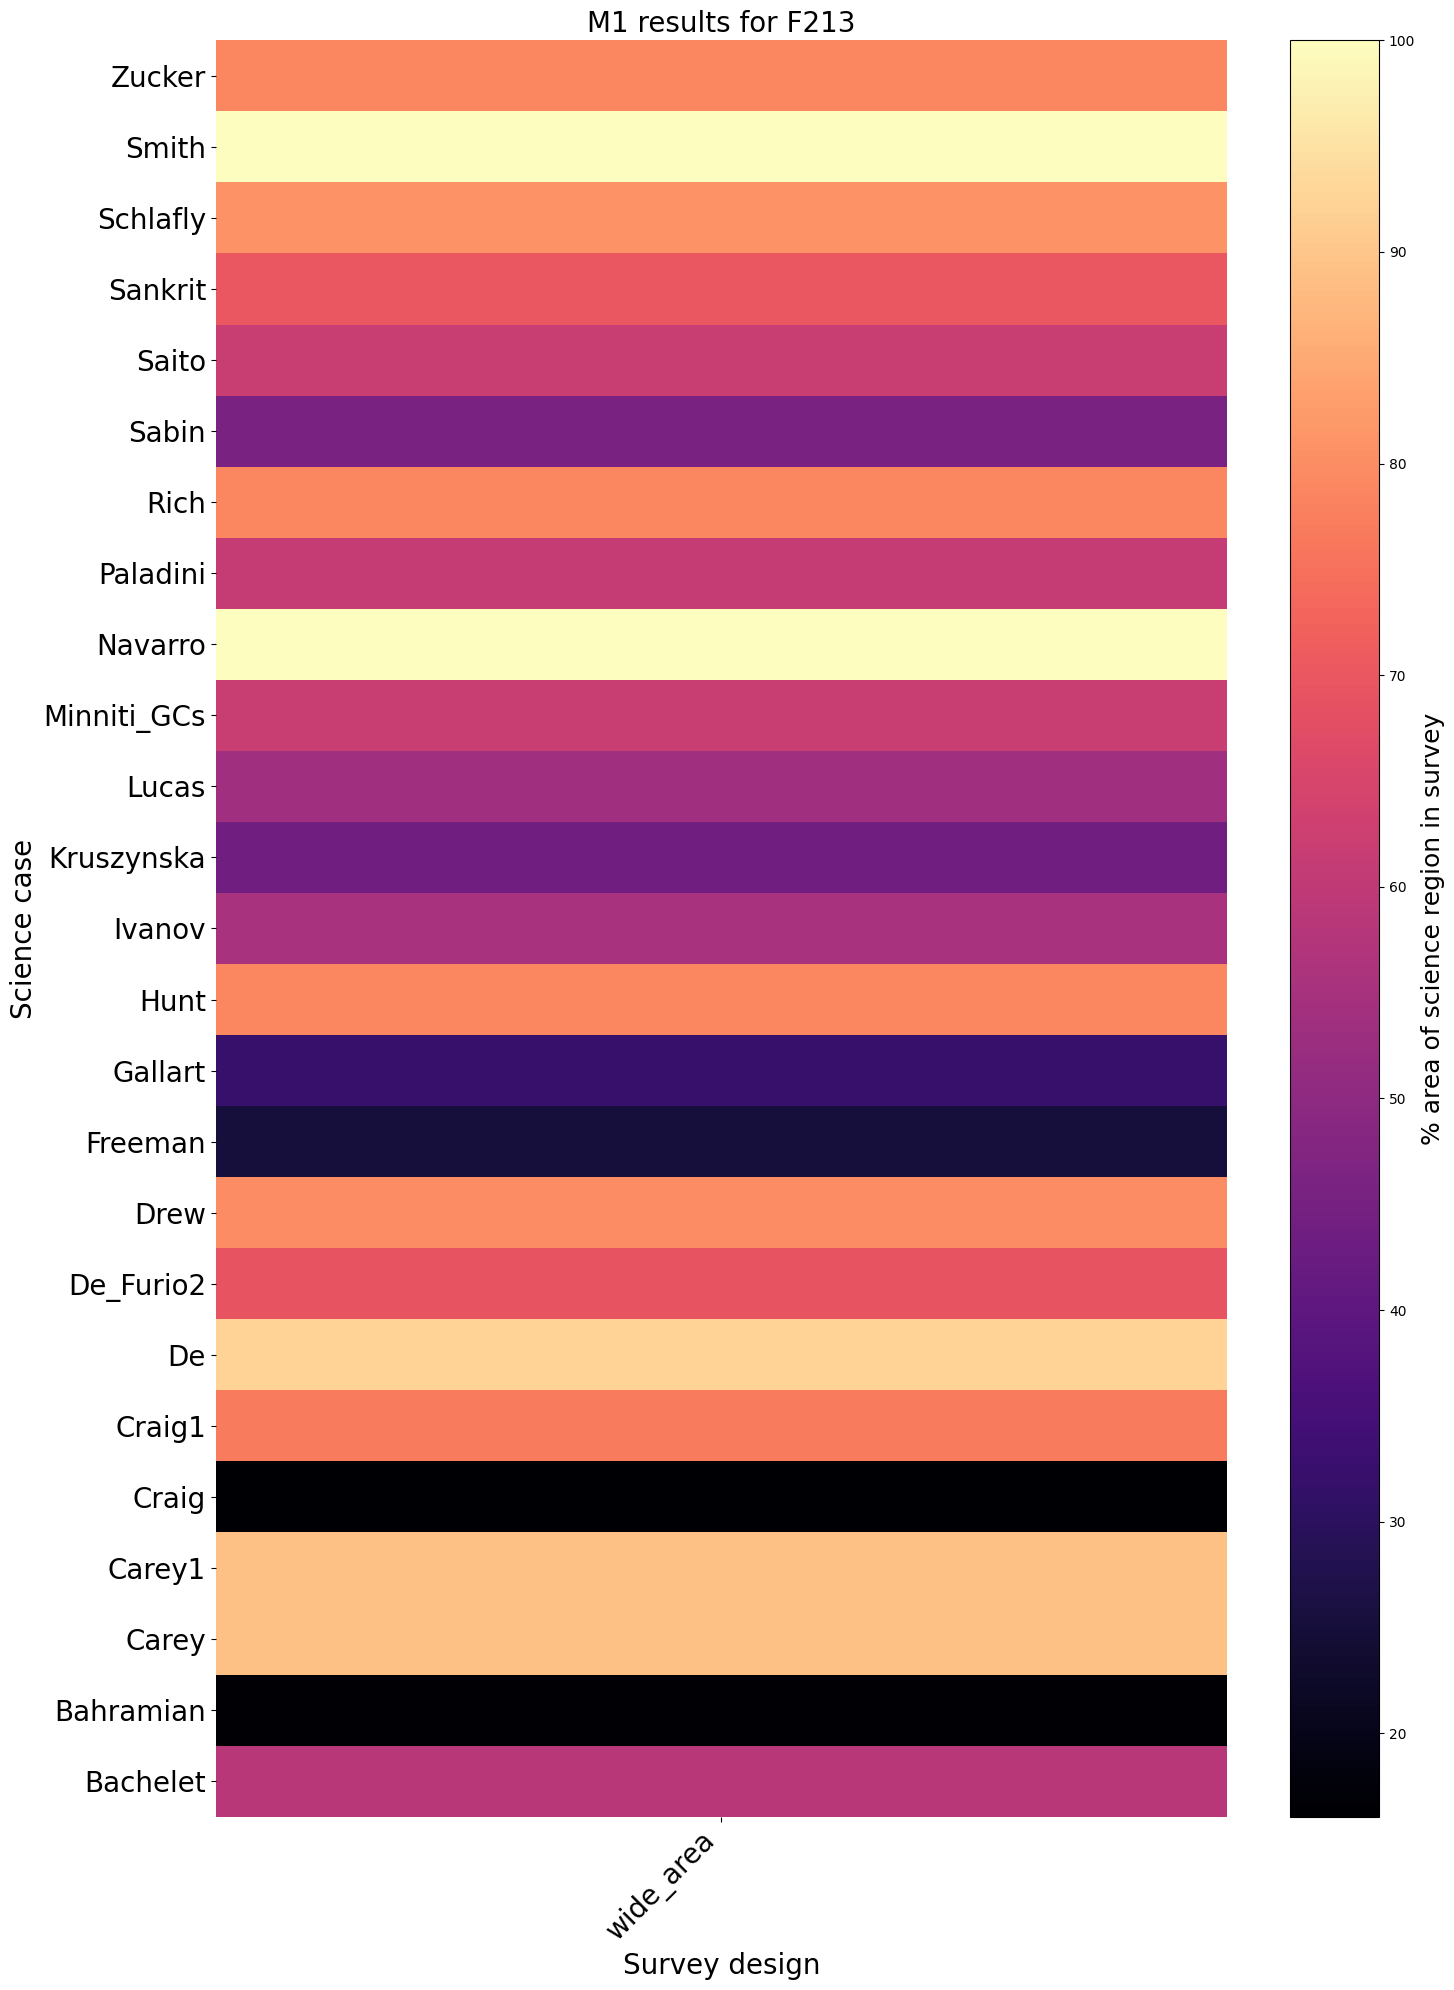

In [9]:
optic = 'F213'

plot_metric_heatmap(optic, m1_results, 'M1_%pix', '% area of science region in survey')
plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm1_results_heatmap_' + category + '_' + optic + '.png'))


Science cases that did not request the filter given are not plotted by this function.  The metric represents the percentage of the desired area for a given science case that is included within a survey footprint, so we can interpret low metric values to mean that the survey design does not include the requested region.  Conversely, brighter regions indicate a survey strategy that better serves the needs of the science case.

It is also informative to evaluate this metric by science topic.  This can be done using the 'category' parameter assigned to each science case.  

In [ ]:
# Load the science region definitions
# Note that the category information is also available from the computed regions but this tends to exceed notebook memory limits
science_cases = config_utils.read_config(path.join(getcwd(), '..', 'config', 'rgps_science_cases.json'))

In [ ]:
# Build a dictionary of the unique categories of science proposal from the loaded science regions, and list all the proposals 
# under each category
science_categories = {}
for author, science_strategy in science_cases.items():
    if science_strategy['category'] in science_categories.keys():
        science_categories[science_strategy['category']].append(author)
    else:
        science_categories[science_strategy['category']] = [author]
science_categories

In [ ]:
def select_results(metric_results, author_list, optic_list, survey_list):
    """
    Function to down-select the table of metric results by the name of the author of a science case, optic and survey design.
    """

    rows = []
    for entry in metric_results:
        if entry['Science_case'] in author_list \
            and entry['Optic'] in optic_list \
                and entry['Survey_strategy'] in survey_list:
            rows.append(entry)
    
    sub_results = Table(rows=rows, names=metric_results.colnames)

    return sub_results

In [ ]:
sfr_results = select_results(m1_results, science_categories['SFR'], optic_list=['F213'], survey_list=all_survey_regions.keys())
sfr_results

We can now compare the metric results for various proposals within the same science topic

In [ ]:
# Star Forming Regions
plot_metric_heatmap('F213', sfr_results, 'M1_%pix', '% area of science region in survey')
plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm1_results_heatmap_F213_SFR.png'))
plt.close()

In [ ]:
# Wide Field Survey science cases
wfs_results = select_results(m1_results, science_categories['wide-area'], optic_list=['F213'], survey_list=all_survey_regions.keys())

plot_metric_heatmap('F213', wfs_results, 'M1_%pix', '% area of science region in survey')
plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm1_results_heatmap_F213_wide_field.png'))
plt.close()

It helps to illustrate the results from this metric by comparing the survey sky map with those of the science cases.

In [ ]:
# Load the requested science regions for these selected science cases
author = 'De_Furio'
survey_option = 'Option_1a'
optic = 'F213'

# Load a set of cases for a science category
#case_set = {author: science_cases[author] for author in science_categories[science_category]}

# Load a single science case
case_set = {author: science_cases[author]}

# Build the regions for this set of cases
science_regions_set = regions.build_region_maps(sim_config, case_set)

In [ ]:
# Merge all the requested regions for all science cases for this topic into a single region for convenience of plotting 
region_list = []
for author, info in science_regions_set.items():
    for f in sim_config['OPTICAL_COMPONENTS']:
        if f in info.keys():
            for region in info[f]:
                region_list.append(region)
                
r_merge = regions.combine_regions(region_list)

In [ ]:
# Plot the combined science regions
mw1 = r_merge.sky_plot(
    title = 'De Furio regions and survey design ' + survey_option + ' and ' + optic, 
    plot_color='y',
    plot_alpha=0.3
)

# Overplot the selected survey design
if len(all_survey_regions[survey_option][optic]) == 0:
    print('WARNING: Survey design ' + survey_option + ' has no region using optic ' + optic)

else:
    for r in all_survey_regions[survey_option][optic]:
        s = r.pixels_to_skycoords()
        mw1.scatter(s.ra.deg*u.deg, s.dec.deg*u.deg, c="r", s=5, alpha=0.4)

plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm1_results_heatmap_F213_defurio.png'))
plt.close()

From the sky plot above it is clear that there is minimal overlap between the De_Furio science regions and the Option 1a survey design. 
This tallies with the computed metric values:

In [ ]:
m1_defurio = select_results(m1_results, ['De_Furio'], optic_list=['F213'], survey_list=[survey_option])
m1_defurio

Whereas we can compare this with the overlap of survey design Option_6b and Zari:

In [ ]:
survey_option = 'Option_6b' 
optic = 'F213' 
author = 'Zari'

m1_zari = select_results(m1_results, [author], optic_list=[optic], survey_list=[survey_option])
m1_zari

In [ ]:
case_set = {author: science_cases[author]}

science_regions_set = regions.build_region_maps(sim_config, case_set)

region_list = []
for author, info in science_regions_set.items():
    for f in sim_config['OPTICAL_COMPONENTS']:
        if f in info.keys():
            for region in info[f]:
                region_list.append(region)
                
r_merge = regions.combine_regions(region_list)

# Plot the combined science regions
plt.close()
mw2 = r_merge.sky_plot(
    title = 'Zari regions and survey design ' + survey_option + ' and ' + optic, 
    plot_color='y',
    plot_alpha=0.3
)

# Overplot the selected survey design
if len(all_survey_regions[survey_option][optic]) == 0:
    print('WARNING: Survey design ' + survey_option + ' has no region using optic ' + optic)

else:
    for r in all_survey_regions[survey_option][optic]:
        s = r.pixels_to_skycoords()
        mw2.scatter(s.ra.deg*u.deg, s.dec.deg*u.deg, c="r", s=5, alpha=0.4)

plt.tight_layout()
plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm1_results_heatmap_F213_zari.png'))
plt.close()

In [ ]:
survey_option = 'Option_1b' 
optic = 'F213' 
author = 'Paladini'

m1_paladini = select_results(m1_results, [author], optic_list=[optic], survey_list=[survey_option])
m1_paladini

In [ ]:
case_set = {author: science_cases[author]}

science_regions_set = regions.build_region_maps(sim_config, case_set)

region_list = []
for author, info in science_regions_set.items():
    for f in sim_config['OPTICAL_COMPONENTS']:
        if f in info.keys():
            for region in info[f]:
                region_list.append(region)
                
r_merge = regions.combine_regions(region_list)

# Plot the combined science regions
plt.close()
mw2 = r_merge.sky_plot(
    title = 'Paladini regions and survey design ' + survey_option + ' and ' + optic, 
    plot_color='y',
    plot_alpha=0.3
)

# Overplot the selected survey design
if len(all_survey_regions[survey_option][optic]) == 0:
    print('WARNING: Survey design ' + survey_option + ' has no region using optic ' + optic)

else:
    for r in all_survey_regions[survey_option][optic]:
        s = r.pixels_to_skycoords()
        mw2.scatter(s.ra.deg*u.deg, s.dec.deg*u.deg, c="r", s=5, alpha=0.4)

plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm1_results_heatmap_F213_paladini.png'))
plt.close()

## M2 Star Counts

Star counts is a useful proxy for the total number of different stellar variables that can be expected in the survey.

In [ ]:
# Load the M1 metric results
m2_results_file = path.join(getcwd(), '..', 'metric_results', 'M2_star_counts_results.txt')

m2_results = Table.read(m2_results_file, format='ascii')
m2_results

Since this metric simply estimates the total number of stars we can expect to be within a given survey region, the results data can be plotted more simply as a function of the survey strategy (and hence footprint) and filter.  

In [ ]:
# Select the metric results for the current filter and all science cases and survey designs
optic = 'F213'
idx = np.where(m2_results['Optic'] == optic)
metric_filter = m2_results[idx]

survey_options = list(set(m2_results['Survey_strategy'].data))
survey_options.sort()

# Compile the data for plotting
data = []
for survey_name in survey_options:
    jdx = np.where(metric_filter['Survey_strategy'] == survey_name)[0]
    data.append(np.log10(metric_filter[jdx]['M2_nstars'][0]))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

ax.plot(range(0,len(survey_options),1), data, 'mo')
ax.plot(range(0,len(survey_options),1), data, color='grey', linestyle='-')
ax.set_xlabel('Survey strategy', fontsize=20)
ax.set_ylabel('$log_{10}$(Nstars in footprint)', fontsize=20)
ax.set_title('M2 for ' + optic, fontsize=20)
ax.set_xticks(range(0,len(survey_options),1))
ax.set_xticklabels(survey_options, rotation=45.0, horizontalalignment='right', fontsize=20)
yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, fontsize=20, horizontalalignment='right')
ax.grid()

plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm2_results_all_surveys.png'))
plt.close()

NOTE: There is no brightness cut made in this metric, and extinction is not yet included.

## M3 Extended region count

A number of science cases expressed an interest in observing as many targets as possible from a known catalog of objects.  There are several examples of these, including Open and Globular Clusters, Star Forming Regions, and Active Galactic Nuclei.  The metrics to evaluate these cases are fundamentally the same - calculating the percentage (by area) of the target catalog to receive observations in the requested filters - the code was combined into a single metric which accepts different target catalogs of interest. 

It is therefore most relevant to examine the results of this metric for those science cases which cited input target catalogs rather than all of them. These can be found by searching the rgps_science_cases.json file for science cases with input 'catalog'. These include:

* DAmmando - jetted AGN
* Villasenor - Young massive stars in HII regions
* De_Furio - Star Forming Regions
* Globular_clusters
* Open_clusters

In [ ]:
# Load the M1 metric results
m3_results_file = path.join(getcwd(), '..', 'metric_results', 'M3_extended_region_count_results.txt')

m3_results = Table.read(m3_results_file, format='ascii')
m3_results

### De_Furio - Star Forming Regions

Since the observing strategies requested for the different catalogs of objects are distinct, it is worth exploring the metric results individually.  Let's start with Star Forming Regions, since this was a common use-case. 

In [ ]:
# Select the metric results for the De Furio catalog of SFR
idx = np.where(m3_results['Science_case'] == 'De_Furio')
sfr_results = m3_results[idx]
sfr_results

In [ ]:
def plot_metric_multifilter(results, metric_name, sim_config, metric_label, science_name='all'): 
    """
    Function to plot metric values for a given science use case over multiple survey designs, for multiple filters.

    Input
        selected_results  Table   Metric results table selecting the output for a specific science case only.
    """

    # Select the results for the specified science case
    if science_name != 'all':
        idx = np.where(results['Science_case'] == science_name)
        selected_results = results[idx]
    else: 
        selected_results = results

    # Identify which filters were requested for this science case
    filter_set = list(set(selected_results['Optic'].data))
    filter_set.sort()
    
    # Make a list of the survey strategies included 
    surveys_options = list(set(selected_results['Survey_strategy'].data))
    survey_options.sort()

    # Plot the metric results 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

    for optic in filter_set:

        fdx = selected_results['Optic'] == optic
        metric_filter = selected_results[fdx]
        
        data = []
        for survey_name in survey_options:
            jdx = np.where(metric_filter['Survey_strategy'] == survey_name)[0]
            data.append(metric_filter[jdx][metric_name][0])

        ax.plot(range(0,len(survey_options),1), data, 
                color=sim_config['PLOT_COLORS'][optic], marker=sim_config['PLOT_SYMBOLS'][optic],
               label=optic)
        ax.plot(range(0,len(survey_options),1), data, color=sim_config['PLOT_COLORS'][optic], linestyle='-')

    ax.set_xlabel('Survey strategy', fontsize=20)
    ax.set_ylabel(metric_label, fontsize=20)
    ax.set_title(metric_name + ' for ' + science_name + ' catalog', fontsize=20)
    ax.set_xticks(range(0,len(survey_options),1))
    ax.set_xticklabels(survey_options, rotation=45.0, horizontalalignment='right', fontsize=20)
    yticklabels = ax.get_yticklabels()
    ax.set_yticklabels(yticklabels, fontsize=20, horizontalalignment='right')
    ax.legend()
    ax.grid()

    plt.tight_layout()
    plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm3_results.png'))
    plt.close()

In [ ]:
plot_metric_multifilter(m3_results, 'M3_%regions', sim_config, '% of catalog regions in survey', science_name='De_Furio')

Bearing in mind that this metric returns a percentage of the total area covered by these Star Forming Regions, these results indicate a low coverage.  However, many SFRs subtend large areas as seen from Earth, so summing this metric over all known SFRs may not be the most valuable metric here.  

Instead, some catalogs include a priority flag to indicate which targets are highest priority, and this metric could be tailored to focus on this subset of targets. 

This can be illustrated by considering some of the science cases that proposed a smaller subset of SFR targets, such as Werner who requested coverage of Orion SFR, Rho Ophiuchi SFR, and Taurus SFR.  Unfortunately the current survey designs provide no coverage of these regions. 

The other caveat with this metric design is that a target must be fully within the survey footprint to count as "included".  For some targets, even partial coverage may be useful, and this metric could be revised to make this the case. 

### Globular and Open Clusters 

We can repeat this analysis for the catalogs of star clusters that have been included.

In [ ]:
plot_metric_multifilter(m3_results, 'M3_%regions', sim_config, '% of catalog regions in survey', science_name='Globular_Clusters')

In [ ]:
plot_metric_multifilter(m3_results, 'M3_%regions', sim_config, '% of catalog regions in survey', science_name='Open_Clusters')

This metric once again returns very low percentage coverage for Open Clusters because many of them subtend large areas of the sky that lie outside the Galactic Plane.  These are unlikely to ever be in the survey design.  A more effective metric would include priority information and assess high-priority candidate clusters, SFRs etc.

In [ ]:
author = 'Globular_Clusters' 
survey_option = 'Option_1a' 
optic = 'F213' 

case_set = {author: science_cases[author]}

science_regions_set = regions.build_region_maps(sim_config, case_set)

region_list = []
for author, info in science_regions_set.items():
    for f in sim_config['OPTICAL_COMPONENTS']:
        if f in info.keys():
            for region in info[f]:
                region_list.append(region)
                
r_merge = regions.combine_regions(region_list)

# Plot the combined science regions
plt.close()
mw2 = r_merge.sky_plot(
    title = 'Globular clusters and survey design ' + survey_option + ' and ' + optic, 
    plot_color='y',
    plot_alpha=0.5
)

# Overplot the selected survey design
if len(all_survey_regions[survey_option][optic]) == 0:
    print('WARNING: Survey design ' + survey_option + ' has no region using optic ' + optic)

else:
    for r in all_survey_regions[survey_option][optic]:
        s = r.pixels_to_skycoords()
        mw2.scatter(s.ra.deg*u.deg, s.dec.deg*u.deg, c="r", s=5, alpha=0.4)

plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm3_results_skymap_gcs.png'))
plt.close()

### Villasenor - Young massive stars in HII regions

In [ ]:
plot_metric_multifilter(m3_results, 'M3_%regions', sim_config, '% of catalog regions in survey', science_name='Villasenor')

## M5 Proper Motion Precision

This metric estimates the precision to which proper motions can be measured within surveyed regions.  A threshold of 1 mas is adopted as the desired precision goal, to enable a range of science.  The metric value represents the percentage of the survey region where this threshold is met. 

### Add visualizations for this metric, including heatmaps and sky plots

In [ ]:
# Load the M5 metric results
m5_results_file = path.join(getcwd(), '..', 'metric_results', 'M5_proper_motion_precision_results.txt')

m5_results = Table.read(m5_results_file, format='ascii')
m5_results

This results table has non-standard columns due to the nature of the output.

In [ ]:
# Select data for a specific filter and concatenate the survey and region labels for plotting

rows = []
for entry in m5_results:
    rows.append([
        entry['Survey_strategy'] + '_' + entry['Survey_region'], 
        entry['Optic'],
        entry['M5_proper_motion_precision']
    ])

sub_results = Table(rows=rows, names=['Survey_region', 'Optic', 'M5_proper_motion_precision'])
sub_results

In [ ]:
# Create plot of survey strategy and region for a given filter versus metric 
# Make a list of the survey strategies included 
survey_options = list(set(sub_results['Survey_region']))
survey_options.sort()

fontsize = 14

# Plot the metric results 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))

for optic in sim_config['OPTICAL_COMPONENTS']:

    fdx = sub_results['Optic'] == optic
    metric_filter = sub_results[fdx]
    
    xdata = []
    ydata = []
    for k,survey_name in enumerate(survey_options):
        jdx = np.where(metric_filter['Survey_region'] == survey_name)[0]

        if len(jdx) > 0:
            xdata.append(k)
            ydata.append(metric_filter[jdx]['M5_proper_motion_precision'][0])

    if len(xdata) > 0:
        ax.plot(xdata, ydata, 
                color=sim_config['PLOT_COLORS'][optic], marker=sim_config['PLOT_SYMBOLS'][optic],
               label=optic)
        ax.plot(xdata, ydata, color=sim_config['PLOT_COLORS'][optic], linestyle='-')

ax.set_xlabel('Survey strategy', fontsize=fontsize)
ax.set_ylabel('Percentage of region', fontsize=fontsize)
ax.set_title('M5_proper_motion_precision', fontsize=fontsize)
ax.set_xticks(range(0,len(survey_options),1))
ax.set_xticklabels(survey_options, rotation=45.0, horizontalalignment='right', fontsize=20)
yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, fontsize=fontsize, horizontalalignment='right')
[xmin,xmax] = ax.get_xlim()
ax.set_xlim([xmin, xmax*1.15])
ax.legend(fontsize=fontsize)
ax.grid()

output = False
if output:
    plt.tight_layout()
    plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm5_results.png'))
    plt.close()

## M6 Sky Area Optical Element

This metric evaluates the total area of sky to receive observations in each optical element, and combinations of the filters, as a proxy for color measurements.

This metric calculates two separate values.  The first metric (M6_%sky_area_single_filter) simply calculates the total sky area of the survey foorprint to receive coverage in a given single filter.  

The second metric, M6_sky_area_filter_combo, calculates the sky area to receive observations in multiple filters.  An outstanding question is what combinations of filters would be most valuable for measuring colors, so for the time being we adopt the following default set: 

* ('F129', 'F184'),
* ('F184', 'F213'),
* ('F129', 'F158', 'F213')

Note that both of these metrics return values in sky area in square degrees, not percentages. 

In [ ]:
# Load the M6 metric results
m6_results_file = path.join(getcwd(), '..', 'metric_results', 'M6_sky_area_optical_elements_results.txt')

m6_results = Table.read(m6_results_file, format='ascii')
m6_results

In [ ]:
# Plot the sky area covered in different single filters for each survey strategy

# Make a list of the survey strategies included 
surveys_options = list(set(m6_results['Survey_strategy'].data))
survey_options.sort()

# Plot the metric results 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

for optic in sim_config['OPTICAL_COMPONENTS']:

    fdx = m6_results['Optic'] == optic
    metric_filter = m6_results[fdx]
    
    data = []
    for survey_name in survey_options:
        jdx = np.where(metric_filter['Survey_strategy'] == survey_name)[0]
        data.append(metric_filter[jdx]['M6_sky_area_single_filter'][0])

    ax.plot(range(0,len(survey_options),1), data, 
            color=sim_config['PLOT_COLORS'][optic], marker=sim_config['PLOT_SYMBOLS'][optic],
           label=optic)
    ax.plot(range(0,len(survey_options),1), data, color=sim_config['PLOT_COLORS'][optic], linestyle='-')

ax.set_xlabel('Survey strategy', fontsize=20)
ax.set_ylabel('Sky area [sq. deg.]', fontsize=20)
ax.set_title('M6_sky_area_single_filter', fontsize=20)
ax.set_xticks(range(0,len(survey_options),1))
ax.set_xticklabels(survey_options, rotation=45.0, horizontalalignment='right', fontsize=20)
yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, fontsize=20, horizontalalignment='right')
[xmin,xmax] = ax.get_xlim()
ax.set_xlim([xmin, xmax*1.4])
ax.legend()
ax.grid()
plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm6_results_sky_area_single_filter.png'))
plt.close()

The second metric, M6_sky_area_filter_combo, calculates the area of the survey region to receive observations in combinations of filters. 

In [ ]:
# Extract from the metric results entries referring to combinations of multiple filters and make a list of the combinations included.
flist = []
for f in m6_results['Optic']: 
    if ',' in f:
        flist.append(f)
filter_sets = list(set(flist)) 

plot_colors = ["#3303ab", "#0344a6", "#04b8ac", "#058c01", "#ab6902", "#7a0701", "#7d039c", "#080f17", "#333033"]
plot_symbols = ["o", "v", "s", "p", "d", "P", "*", "<", ">"]

# Make a list of the survey strategies included 
surveys_options = list(set(m6_results['Survey_strategy'].data))
survey_options.sort()

# Plot the metric results 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

for i,fset in enumerate(filter_sets):

    fdx = m6_results['Optic'] == fset
    metric_filter = m6_results[fdx]

    data = []
    for survey_name in survey_options:
        jdx = np.where(metric_filter['Survey_strategy'] == survey_name)[0]
        data.append(metric_filter[jdx]['M6_sky_area_filter_combo'][0])

    ax.plot(range(0,len(survey_options),1), data, 
            color=plot_colors[i], marker=plot_symbols[i],
           label=fset)
    ax.plot(range(0,len(survey_options),1), data, color=plot_colors[i], linestyle='-')

ax.set_xlabel('Survey strategy', fontsize=18)
ax.set_ylabel('Sky area [sq. deg.]', fontsize=18)
ax.set_title('M6_sky_area_filter_combo', fontsize=20)
ax.set_xticks(range(0,len(survey_options),1))
ax.set_xticklabels(survey_options, rotation=45.0, horizontalalignment='right', fontsize=20)
yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, fontsize=18, horizontalalignment='right')
[ymin,ymax] = ax.get_ylim()
ax.set_ylim([ymin, ymax*1.8])
ax.legend(loc='upper right')
ax.grid()
plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm6_results_sky_area_filter_combo.png'))
plt.close()

Note that some filter options receive the same survey area in some strategies, leading to different options being overplotted. 

This metric might be more useful if it compared the survey design areas with those requested by science cases that need more than one filter.

## M7 Sky area revisits - Time domain metric 

All science cases, by definition, require at least one visit to all HEALpixels in their desired survey region, while some indicate that multiple visits would be needed.  The M7 metric calculates the area of a desired survey region to actually receive the requested number of visits in a survey strategy and compares this with the requested cadence.  The result is expressed as a percentage of the requested visits, M7_%sky_area_nvisits.

Unlike the other metrics, this calculation is made separately for each region within a (science case, filter) or (survey design, filter) combination.  This is because some cases request different cadence strategies for different sub-regions.  

As a result, the metric output is quite complicated, and its best evaluated in smaller segments.

In [ ]:
# Load the M7 metric results
m7_results_file = path.join(getcwd(), '..', 'metric_results', 'M7_sky_area_nvisits_results.txt')

m7_results = Table.read(m7_results_file, format='ascii')
m7_results

In [ ]:
# Select a science case and filter to evaluate and downselect the results table. 
# This returns a subtable with the metric results for all survey designs for this combination of filter and science case
optic = 'F213' 
case = 'Paladini2'

idx = np.where(m7_results['Optic'] == optic)
metric_results = m7_results[idx]
idx = np.where(metric_results['Science_case'] == case)
metric_results = metric_results[idx]
metric_results

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,20))

# List the individual survey regions for each survey design
survey_regions = list(set(metric_results['Survey_region'].data))
survey_regions.sort()

# Similarly, list the regions from the science case
science_regions = list(set(metric_results['Science_region'].data))
science_regions.sort()

data = np.zeros( (len(survey_regions),len(science_regions)) )

# Select all metric results for the current filter
for isurvey,rsurvey in enumerate(survey_regions):
    jdx = np.where(metric_results['Survey_region'] == rsurvey)[0]
    
    for iscience, rscience in enumerate(science_regions):
        kdx = np.where(metric_results[jdx]['Science_region'] == rscience)[0]

        # Not all science cases request all filters, so it is possible to have no results here
        if len(metric_results[jdx][kdx]) > 0:
            data[isurvey,iscience] = metric_results[jdx][kdx]['M7_%sky_area_nvisits'].data

# The plotted grids for a heat map have to account for Python's indexing
xgrid = np.arange(0,len(science_regions)+1,1)
ygrid = np.arange(0,len(survey_regions)+1,1)

# Plot normalised metric data
norm = mpl.colors.Normalize(data.min(), data.max())
ax.pcolormesh(xgrid, ygrid, data, cmap="magma", norm=norm)

# Label axes
ax.set_frame_on(False)

ax.set_xticks(xgrid[0:-1]+0.5)
ax.set_yticks(ygrid[0:-1]+0.5)
ax.set_ylabel('Survey region', fontsize=20)
ax.set_xlabel('Science region', fontsize=20)
ax.set_title('M7 results for ' + case + ' and ' + optic, fontsize=20)
ax.set_xticklabels(science_regions, rotation=45.0, horizontalalignment='right', fontsize=20)
ax.set_yticklabels(survey_regions, fontsize=20, horizontalalignment='right')

cb = fig.colorbar(
        ScalarMappable(norm=norm, cmap="magma"),
        ax=ax, # Pass the new axis
        orientation = "vertical")
cb.set_label('M7 %area to receive nvisits', fontsize=18)

plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm7_results_sky_area_nvisits_paladini2_F213.png'))
plt.close()